In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv("../data/master_data_by_category.csv")

## 2022년 데이터를 기준으로 단면 데이터셋 생성

In [5]:

df_2022 = df[['Country', 'category', '2022']].copy()
df_2022.rename(columns={'2022': 'Value'}, inplace=True)
df_2022['Value'] = pd.to_numeric(df_2022['Value'], errors='coerce').round(4)
print(df_2022.head())

   Country       category  Value
0    China  Corporate Tax   25.0
1   France  Corporate Tax   25.8
2  Germany  Corporate Tax   29.9
3    Japan  Corporate Tax   29.7
4    Korea  Corporate Tax   27.5


### 2. Wide format으로 pivot: 각 행은 Country, 각 열은 category별 2022값

In [6]:
df_wide = df_2022.pivot(index='Country', columns='category', values='Value').reset_index()
print("\nWide format 데이터 미리보기:")
print(df_wide.head())


Wide format 데이터 미리보기:
category  Country  Business sophistication  Corporate Tax  Creative outputs  \
0           China                     55.9           25.0              49.3   
1          France                     53.2           25.8              52.5   
2         Germany                     52.7           29.9              52.3   
3           Japan                     58.1           29.7              38.9   
4           Korea                     58.0           27.5              55.1   

category           GDP  GDP_per_capita_PPP    GERD  GNI_per_capita  \
0         1.788180e+13          18263.7579  2.5552         11210.0   
1         2.796300e+12          48859.9247  2.2331         41690.0   
2         4.163600e+12          56386.0680  3.1324         49280.0   
3         4.256410e+12          42191.4043  3.4054         41410.0   
4         1.673920e+12          44112.1164  5.2108         33380.0   

category  General Revenue  Global Innovation Index  \
0                 15.0125  

# Multiple Regression

- 종속: GDP, 독립: 나머지

In [ ]:
if 'GDP' not in df_wide.columns:
    print("error: GDP 존재하지 않음음")
else:
    y = df_wide['GDP']
    X = df_wide.drop(columns=['Country', 'GDP'])
    # 상수항 추가
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print("\n다중 회귀 분석 결과:")
    print(model.summary())


다중 회귀 분석 결과:
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 11 Mar 2025   Prob (F-statistic):                nan
Time:                        20:27:13   Log-Likelihood:                -9.6768
No. Observations:                   7   AIC:                             33.35
Df Residuals:                       0   BIC:                             32.98
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


# Clustering

In [8]:
# 결측치 제거
df_cluster = df_wide.dropna().copy()
X_cluster = df_cluster.drop(columns=['Country'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [10]:
# KMeans 클러스터링 (클러스터 수 = 3 예시)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)
print("\n클러스터링 결과 (국가별):")
print(df_cluster[['Country', 'Cluster']])


클러스터링 결과 (국가별):
category                   Country  Cluster
0                            China        2
1                           France        0
2                          Germany        0
3                            Japan        0
4                            Korea        0
5                   United Kingdom        0
6         United States of America        1


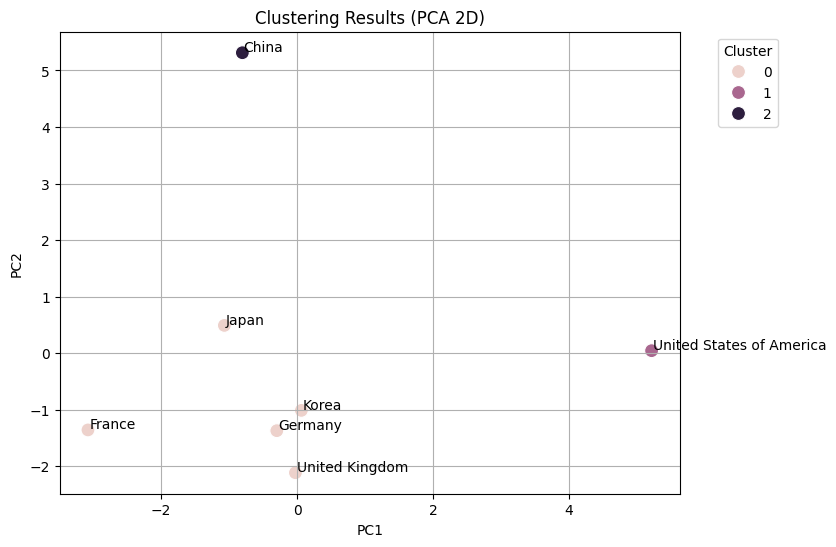

In [11]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
df_cluster['PC1'] = pcs[:, 0]
df_cluster['PC2'] = pcs[:, 1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='Cluster', s=100)
for i in range(df_cluster.shape[0]):
    plt.text(df_cluster.loc[i, 'PC1']+0.02, df_cluster.loc[i, 'PC2']+0.02, df_cluster.loc[i, 'Country'])
plt.title("Clustering Results (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# PCA

In [12]:
X_pca = df_wide.drop(columns=['Country']).copy()
X_pca = X_pca.dropna()
countries_pca = df_wide.loc[X_pca.index, 'Country'].values

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)
pca_full = PCA(n_components=2)
pcs_full = pca_full.fit_transform(X_pca_scaled)
df_pca = pd.DataFrame(pcs_full, columns=['PC1', 'PC2'])
df_pca['Country'] = countries_pca
explained_var = pca_full.explained_variance_ratio_

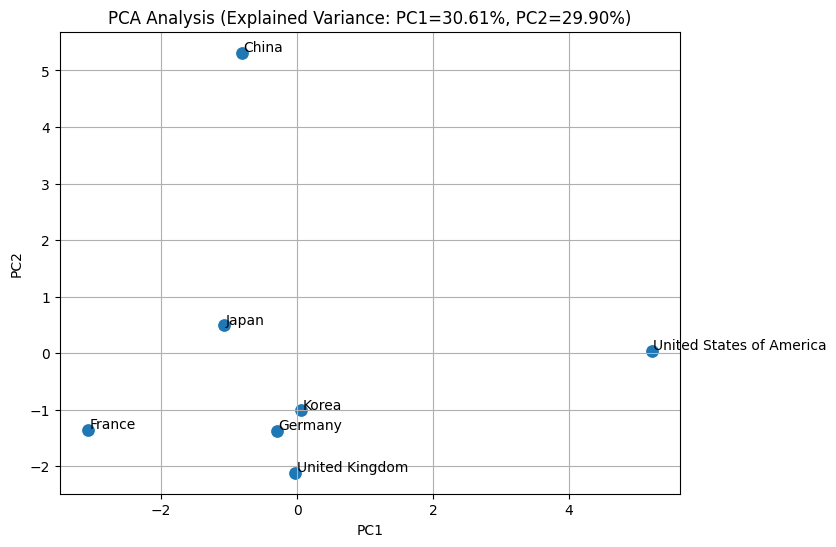

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', s=100)
for i in range(df_pca.shape[0]):
    plt.text(df_pca.loc[i, 'PC1']+0.02, df_pca.loc[i, 'PC2']+0.02, df_pca.loc[i, 'Country'])
plt.title(f"PCA Analysis (Explained Variance: PC1={explained_var[0]*100:.2f}%, PC2={explained_var[1]*100:.2f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()